## Importing some necessary packages. 

### Note

You'll need transformers from Huggingface to run this notebook. 

In [1]:
import time
from transformers import Trainer
import sys
import os
import math
from transformers.debug_utils import DebugOption, DebugUnderflowOverflow

from transformers.utils import(
    is_sagemaker_mp_enabled,
    is_torch_tpu_available,
    logging,
)
from tqdm.auto import tqdm
from transformers.deepspeed import deepspeed_init
from transformers.trainer_utils import(
    HPSearchBackend,
    ShardedDDPOption,
    TrainOutput,
    has_length,
    speed_metrics,
)
from transformers.trainer_pt_utils import IterableDatasetShard

from transformers.pytorch_utils import is_torch_less_than_1_11
from transformers.integrations import hp_params


import torch.distributed as dist

from transformers.trainer_callback import TrainerState
import torch
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.distributed import DistributedSampler

import numpy as np
from datasets import load_metric
from transformers import pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import TrainingArguments
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from huggingface_hub import notebook_login
from datasets import load_dataset


TRAINING_ARGS_NAME = "training_args.bin"
TRAINER_STATE_NAME = "trainer_state.json"
OPTIMIZER_NAME = "optimizer.pt"
SCHEDULER_NAME = "scheduler.pt"
SCALER_NAME = "scaler.pt"

## Custom Trainer and inner_training_loop

In [2]:
class CustomTrainer(Trainer):
    def _inner_training_loop(self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None):
        self._train_batch_size = batch_size
        # Data loader and number of training steps
        train_dataloader = self.get_train_dataloader()

        # Setting up training control variables:
        # number of training epochs: num_train_epochs
        # number of training steps per epoch: num_update_steps_per_epoch
        # total number of training steps to execute: max_steps
        total_train_batch_size = args.train_batch_size * args.gradient_accumulation_steps * args.world_size

        len_dataloader = None
        if has_length(train_dataloader):
            len_dataloader = len(train_dataloader)
            num_update_steps_per_epoch = len_dataloader // args.gradient_accumulation_steps
            num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
            num_examples = self.num_examples(train_dataloader)
            if args.max_steps > 0:
                max_steps = args.max_steps
                num_train_epochs = args.max_steps // num_update_steps_per_epoch + int(
                    args.max_steps % num_update_steps_per_epoch > 0
                )
                # May be slightly incorrect if the last batch in the training dataloader has a smaller size but it's
                # the best we can do.
                num_train_samples = args.max_steps * total_train_batch_size
            else:
                max_steps = math.ceil(args.num_train_epochs * num_update_steps_per_epoch)
                num_train_epochs = math.ceil(args.num_train_epochs)
                num_train_samples = self.num_examples(train_dataloader) * args.num_train_epochs
        elif args.max_steps > 0:  # Rely on max_steps when dataloader does not have a working size
            max_steps = args.max_steps
            # Setting a very large number of epochs so we go as many times as necessary over the iterator.
            num_train_epochs = sys.maxsize
            num_update_steps_per_epoch = max_steps
            num_examples = total_train_batch_size * args.max_steps
            num_train_samples = args.max_steps * total_train_batch_size
        else:
            raise ValueError(
                "args.max_steps must be set to a positive value if dataloader does not have a length, was"
                f" {args.max_steps}"
            )

        if DebugOption.UNDERFLOW_OVERFLOW in self.args.debug:
            if self.args.n_gpu > 1:
                # nn.DataParallel(model) replicates the model, creating new variables and module
                # references registered here no longer work on other gpus, breaking the module
                raise ValueError(
                    "Currently --debug underflow_overflow is not supported under DP. Please use DDP"
                    " (torch.distributed.launch)."
                )
            else:
                debug_overflow = DebugUnderflowOverflow(self.model)  # noqa

        delay_optimizer_creation = (
            self.sharded_ddp is not None
            and self.sharded_ddp != ShardedDDPOption.SIMPLE
            or is_sagemaker_mp_enabled()
            or self.fsdp is not None
        )
        if args.deepspeed:
            deepspeed_engine, optimizer, lr_scheduler = deepspeed_init(
                self, num_training_steps=max_steps, resume_from_checkpoint=resume_from_checkpoint
            )
            self.model = deepspeed_engine.module
            self.model_wrapped = deepspeed_engine
            self.deepspeed = deepspeed_engine
            self.optimizer = optimizer
            self.lr_scheduler = lr_scheduler
        elif not delay_optimizer_creation:
            self.create_optimizer_and_scheduler(num_training_steps=max_steps)

        self.state = TrainerState()
        self.state.is_hyper_param_search = trial is not None

        # Activate gradient checkpointing if needed
        if args.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        model = self._wrap_model(self.model_wrapped)

        if is_sagemaker_mp_enabled() and resume_from_checkpoint is not None:
            self._load_from_checkpoint(resume_from_checkpoint, model)

        # for the rest of this function `model` is the outside model, whether it was wrapped or not
        if model is not self.model:
            self.model_wrapped = model

        if delay_optimizer_creation:
            self.create_optimizer_and_scheduler(num_training_steps=max_steps)

        # Check if saved optimizer or scheduler states exist
        self._load_optimizer_and_scheduler(resume_from_checkpoint)

        self.state.epoch = 0
        start_time = time.time()
        epochs_trained = 0
        steps_trained_in_current_epoch = 0
        steps_trained_progress_bar = None

        # Check if continuing training from a checkpoint
        if resume_from_checkpoint is not None and os.path.isfile(
            os.path.join(resume_from_checkpoint, TRAINER_STATE_NAME)
        ):
            self.state = TrainerState.load_from_json(os.path.join(resume_from_checkpoint, TRAINER_STATE_NAME))
            epochs_trained = self.state.global_step // num_update_steps_per_epoch
            if not args.ignore_data_skip:
                steps_trained_in_current_epoch = self.state.global_step % (num_update_steps_per_epoch)
                steps_trained_in_current_epoch *= args.gradient_accumulation_steps
            else:
                steps_trained_in_current_epoch = 0


            if not args.ignore_data_skip:
                if self.is_local_process_zero() and not args.disable_tqdm:
                    steps_trained_progress_bar = tqdm(total=steps_trained_in_current_epoch)
                    steps_trained_progress_bar.set_description("Skipping the first batches")

        # Update the references
        self.callback_handler.model = self.model
        self.callback_handler.optimizer = self.optimizer
        self.callback_handler.lr_scheduler = self.lr_scheduler
        self.callback_handler.train_dataloader = train_dataloader
        self.state.trial_name = self.hp_name(trial) if self.hp_name is not None else None
        if trial is not None:
            assignments = trial.assignments if self.hp_search_backend == HPSearchBackend.SIGOPT else trial
            self.state.trial_params = hp_params(assignments)
        else:
            self.state.trial_params = None
        # This should be the same if the state has been saved but in case the training arguments changed, it's safer
        # to set this after the load.
        self.state.max_steps = max_steps
        self.state.num_train_epochs = num_train_epochs
        self.state.is_local_process_zero = self.is_local_process_zero()
        self.state.is_world_process_zero = self.is_world_process_zero()

        # tr_loss is a tensor to avoid synchronization of TPUs through .item()
        tr_loss = torch.tensor(0.0).to(args.device)
        # _total_loss_scalar is updated everytime .item() has to be called on tr_loss and stores the sum of all losses
        self._total_loss_scalar = 0.0
        self._globalstep_last_logged = self.state.global_step
        model.zero_grad()

        self.control = self.callback_handler.on_train_begin(args, self.state, self.control)

        # Skip the first epochs_trained epochs to get the random state of the dataloader at the right point.
        if not args.ignore_data_skip:
            for epoch in range(epochs_trained):
                is_random_sampler = hasattr(train_dataloader, "sampler") and isinstance(
                    train_dataloader.sampler, RandomSampler
                )
                if is_torch_less_than_1_11 or not is_random_sampler:
                    # We just need to begin an iteration to create the randomization of the sampler.
                    # That was before PyTorch 1.11 however...
                    for _ in train_dataloader:
                        break
                else:
                    # Otherwise we need to call the whooooole sampler cause there is some random operation added
                    # AT THE VERY END!
                    _ = list(train_dataloader.sampler)

        for epoch in range(epochs_trained, num_train_epochs):
            if isinstance(train_dataloader, DataLoader) and isinstance(train_dataloader.sampler, DistributedSampler):
                train_dataloader.sampler.set_epoch(epoch)
            elif hasattr(train_dataloader, "dataset") and isinstance(train_dataloader.dataset, IterableDatasetShard):
                train_dataloader.dataset.set_epoch(epoch)


         
            epoch_iterator = train_dataloader

            # Reset the past mems state at the beginning of each epoch if necessary.
            if args.past_index >= 0:
                self._past = None

            steps_in_epoch = (
                len(epoch_iterator)
                if len_dataloader is not None
                else args.max_steps * args.gradient_accumulation_steps
            )
            self.control = self.callback_handler.on_epoch_begin(args, self.state, self.control)

            if epoch == epochs_trained and resume_from_checkpoint is not None and steps_trained_in_current_epoch == 0:
                self._load_rng_state(resume_from_checkpoint)

            step = -1
            for step, inputs in enumerate(epoch_iterator):

                # Skip past any already trained steps if resuming training
                if steps_trained_in_current_epoch > 0:
                    steps_trained_in_current_epoch -= 1
                    if steps_trained_progress_bar is not None:
                        steps_trained_progress_bar.update(1)
                    if steps_trained_in_current_epoch == 0:
                        self._load_rng_state(resume_from_checkpoint)
                    continue
                elif steps_trained_progress_bar is not None:
                    steps_trained_progress_bar.close()
                    steps_trained_progress_bar = None

                if step % args.gradient_accumulation_steps == 0:
                    self.control = self.callback_handler.on_step_begin(args, self.state, self.control)

                if (
                    ((step + 1) % args.gradient_accumulation_steps != 0)
                    and args.local_rank != -1
                    and args._no_sync_in_gradient_accumulation
                ):
                    # Avoid unnecessary DDP synchronization since there will be no backward pass on this example.
                    with model.no_sync():
                        tr_loss_step = self.training_step(model, inputs)
                else:
                    tr_loss_step = self.training_step(model, inputs)

                if (
                    args.logging_nan_inf_filter
                    and not is_torch_tpu_available()
                    and (torch.isnan(tr_loss_step) or torch.isinf(tr_loss_step))
                ):
                    # if loss is nan or inf simply add the average of previous logged losses
                    tr_loss += tr_loss / (1 + self.state.global_step - self._globalstep_last_logged)
                else:
                    tr_loss += tr_loss_step

                self.current_flos += float(self.floating_point_ops(inputs))

                # Optimizer step for deepspeed must be called on every step regardless of the value of gradient_accumulation_steps
                if self.deepspeed:
                    self.deepspeed.step()

                if (step + 1) % args.gradient_accumulation_steps == 0 or (
                    # last step in epoch but step is always smaller than gradient_accumulation_steps
                    steps_in_epoch <= args.gradient_accumulation_steps
                    and (step + 1) == steps_in_epoch
                ):
                    # Gradient clipping
                    if args.max_grad_norm is not None and args.max_grad_norm > 0 and not self.deepspeed:
                        # deepspeed does its own clipping

                        if self.do_grad_scaling:
                            # Reduce gradients first for XLA
                            # AMP: gradients need unscaling
                            self.scaler.unscale_(self.optimizer)

                        if is_sagemaker_mp_enabled() and args.fp16:
                            self.optimizer.clip_master_grads(args.max_grad_norm)
                        elif hasattr(self.optimizer, "clip_grad_norm"):
                            # Some optimizers (like the sharded optimizer) have a specific way to do gradient clipping
                            self.optimizer.clip_grad_norm(args.max_grad_norm)
                        elif hasattr(model, "clip_grad_norm_"):
                            # Some models (like FullyShardedDDP) have a specific way to do gradient clipping
                            model.clip_grad_norm_(args.max_grad_norm)

                    # Optimizer step
                    optimizer_was_run = True
                    if self.deepspeed:
                        pass  # called outside the loop
 
                    elif self.do_grad_scaling:
                        scale_before = self.scaler.get_scale()
                        self.scaler.step(self.optimizer)
                        self.scaler.update()
                        scale_after = self.scaler.get_scale()
                        optimizer_was_run = scale_before <= scale_after
                    else:
                        self.optimizer.step()

                    if optimizer_was_run and not self.deepspeed:
                        self.lr_scheduler.step()

                    model.zero_grad()
                    self.state.global_step += 1
                    self.state.epoch = epoch + (step + 1) / steps_in_epoch
                    self.control = self.callback_handler.on_step_end(args, self.state, self.control)

                    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
                else:
                    self.control = self.callback_handler.on_substep_end(args, self.state, self.control)

                if self.control.should_epoch_stop or self.control.should_training_stop:
                    break
            if step < 0:
                self.control.should_training_stop = True

            self.control = self.callback_handler.on_epoch_end(args, self.state, self.control)
            self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)

            if self.control.should_training_stop:
                break

        if args.past_index and hasattr(self, "_past"):
            # Clean the state at the end of training
            delattr(self, "_past")

        if args.load_best_model_at_end and self.state.best_model_checkpoint is not None:
            # Wait for everyone to get here so we are sur the model has been saved by process 0.
            if args.local_rank != -1:
                dist.barrier()

            self._load_best_model()

        # add remaining tr_loss
        self._total_loss_scalar += tr_loss.item()
        train_loss = self._total_loss_scalar / self.state.global_step

        metrics = speed_metrics("train", start_time, num_samples=num_train_samples, num_steps=self.state.max_steps)
        self.store_flos()
        metrics["total_flos"] = self.state.total_flos
        metrics["train_loss"] = train_loss

        self.is_in_train = False

        self._memory_tracker.stop_and_update_metrics(metrics)

        self.log(metrics)

        self.control = self.callback_handler.on_train_end(args, self.state, self.control)

        return TrainOutput(self.state.global_step, train_loss, metrics)

In [3]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchtext
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
from scipy.spatial import distance
import re
import nltk
import spacy
import string
from nltk.corpus import stopwords
pd.options.mode.chained_assignment = None
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import sys 
import torch
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'none\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
from pathlib import Path
import pandas as pd 

def read_csv_file(path):
    dataframe = pd.read_csv(path)
    print("shape of the dataframe: {}".format(dataframe.shape))
    forward_dict = dict()
    backward_dict = dict()
    texts = []
    labels = []
    current_tracker = 0
    for index, row in dataframe.iterrows():
        if row["category"] not in forward_dict:
            forward_dict[row["category"]] = current_tracker
            backward_dict[current_tracker] = row["category"]
            current_tracker += 1
            
    
    for index, row in dataframe.iterrows():
        processed_text = preprocess(row['synopsis'])
        texts.append(processed_text)
        labels.append(forward_dict[row['category']])
        
    return texts, labels, forward_dict, backward_dict

data_texts, data_labels, forward_dict, backward_dict = read_csv_file('reduced_cols.csv')

shape of the dataframe: (7563, 18)


## Train, validation and test split

In [5]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(data_texts, data_labels, test_size= 0.1)

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size= 0.1)

print("Size of train data: {}, valid_data: {}, test_data: {}".format(len(train_texts), len(val_texts), len(test_texts)))

Size of train data: 6125, valid_data: 681, test_data: 757


In [6]:
from transformers import BertTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [7]:
import torch

class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CreateDataset(train_encodings, train_labels)
val_dataset = CreateDataset(val_encodings, val_labels)

In [8]:
 def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis= -1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

## Preprocessing the Data. 

I am using Distilled BERT for sentiment classification, it is faster than BERT due to reduced model complexity and it also retains the most of the performance.

In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

repo_name = "distilled_bert_finetune"

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=60)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

## Defining the arguments and trainer


Training for 25 epochs, with a learning rate of 0.00005 as finetuining requires low learning rate, and batch size of 16

In [10]:
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=1e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=25,
   weight_decay=0.01,
   save_strategy="epoch",
)
 
trainer = CustomTrainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset, 
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

## Start training

In [11]:
trainer.train()

Trainer is attempting to log a value of "{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6', 7: 'LABEL_7', 8: 'LABEL_8', 9: 'LABEL_9', 10: 'LABEL_10', 11: 'LABEL_11', 12: 'LABEL_12', 13: 'LABEL_13', 14: 'LABEL_14', 15: 'LABEL_15', 16: 'LABEL_16', 17: 'LABEL_17', 18: 'LABEL_18', 19: 'LABEL_19', 20: 'LABEL_20', 21: 'LABEL_21', 22: 'LABEL_22', 23: 'LABEL_23', 24: 'LABEL_24', 25: 'LABEL_25', 26: 'LABEL_26', 27: 'LABEL_27', 28: 'LABEL_28', 29: 'LABEL_29', 30: 'LABEL_30', 31: 'LABEL_31', 32: 'LABEL_32', 33: 'LABEL_33', 34: 'LABEL_34', 35: 'LABEL_35', 36: 'LABEL_36', 37: 'LABEL_37', 38: 'LABEL_38', 39: 'LABEL_39', 40: 'LABEL_40', 41: 'LABEL_41', 42: 'LABEL_42', 43: 'LABEL_43', 44: 'LABEL_44', 45: 'LABEL_45', 46: 'LABEL_46', 47: 'LABEL_47', 48: 'LABEL_48', 49: 'LABEL_49', 50: 'LABEL_50', 51: 'LABEL_51', 52: 'LABEL_52', 53: 'LABEL_53', 54: 'LABEL_54', 55: 'LABEL_55', 56: 'LABEL_56', 57: 'LABEL_57', 58: 'LABEL_58', 59: 'LABEL_59'}" for key "id2label

Step,Training Loss
500,3.684400
1000,2.761300
1500,2.139800
2000,1.659800
2500,1.342200
3000,1.086500
3500,0.904900
4000,0.760100
4500,0.641000
5000,0.550900


Saving model checkpoint to distilled_bert_finetune\checkpoint-383
Configuration saved in distilled_bert_finetune\checkpoint-383\config.json
Model weights saved in distilled_bert_finetune\checkpoint-383\pytorch_model.bin
tokenizer config file saved in distilled_bert_finetune\checkpoint-383\tokenizer_config.json
Special tokens file saved in distilled_bert_finetune\checkpoint-383\special_tokens_map.json
Saving model checkpoint to distilled_bert_finetune\checkpoint-766
Configuration saved in distilled_bert_finetune\checkpoint-766\config.json
Model weights saved in distilled_bert_finetune\checkpoint-766\pytorch_model.bin
tokenizer config file saved in distilled_bert_finetune\checkpoint-766\tokenizer_config.json
Special tokens file saved in distilled_bert_finetune\checkpoint-766\special_tokens_map.json
Saving model checkpoint to distilled_bert_finetune\checkpoint-1149
Configuration saved in distilled_bert_finetune\checkpoint-1149\config.json
Model weights saved in distilled_bert_finetune\che

Configuration saved in distilled_bert_finetune\checkpoint-8043\config.json
Model weights saved in distilled_bert_finetune\checkpoint-8043\pytorch_model.bin
tokenizer config file saved in distilled_bert_finetune\checkpoint-8043\tokenizer_config.json
Special tokens file saved in distilled_bert_finetune\checkpoint-8043\special_tokens_map.json
Saving model checkpoint to distilled_bert_finetune\checkpoint-8426
Configuration saved in distilled_bert_finetune\checkpoint-8426\config.json
Model weights saved in distilled_bert_finetune\checkpoint-8426\pytorch_model.bin
tokenizer config file saved in distilled_bert_finetune\checkpoint-8426\tokenizer_config.json
Special tokens file saved in distilled_bert_finetune\checkpoint-8426\special_tokens_map.json
Saving model checkpoint to distilled_bert_finetune\checkpoint-8809
Configuration saved in distilled_bert_finetune\checkpoint-8809\config.json
Model weights saved in distilled_bert_finetune\checkpoint-8809\pytorch_model.bin
tokenizer config file save

TrainOutput(global_step=9575, training_loss=0.9577651459616718, metrics={'train_runtime': 843.9519, 'train_samples_per_second': 181.438, 'train_steps_per_second': 11.345, 'total_flos': 6107378681250000.0, 'train_loss': 0.9577651459616718, 'epoch': 25.0})

## Evaluation on the validation, and test dataset

In [12]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 681
  Batch size = 16


{'eval_loss': 1.3146368265151978,
 'eval_accuracy': 0.6813509544787077,
 'eval_runtime': 1.0005,
 'eval_samples_per_second': 680.687,
 'eval_steps_per_second': 42.98,
 'epoch': 25.0}

In [14]:
model = pipeline("text-classification", model="C:/Users/harsh/OneDrive/Desktop/distilled_bert_60_classes/distilled_bert_finetune/checkpoint-9575")

loading configuration file C:/Users/harsh/OneDrive/Desktop/distilled_bert_60_classes/distilled_bert_finetune/checkpoint-9575\config.json
Model config DistilBertConfig {
  "_name_or_path": "C:/Users/harsh/OneDrive/Desktop/distilled_bert_60_classes/distilled_bert_finetune/checkpoint-9575",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LA

In [15]:
test_input = "jflow set forwarding options sampling family inet command missing cli"
predictions = model(test_input)
predict_label = backward_dict[int(predictions[0]["label"].split('_')[1])]
predict_label

'sw-jsr-flow'

In [16]:
y_real = []
y_pred = []

for index, text in enumerate(test_texts):
    true_label = backward_dict[test_labels[index]]
    predictions = model(text)
    predict_label = backward_dict[int(predictions[0]["label"].split('_')[1])]
    y_real.append(true_label)
    y_pred.append(predict_label)

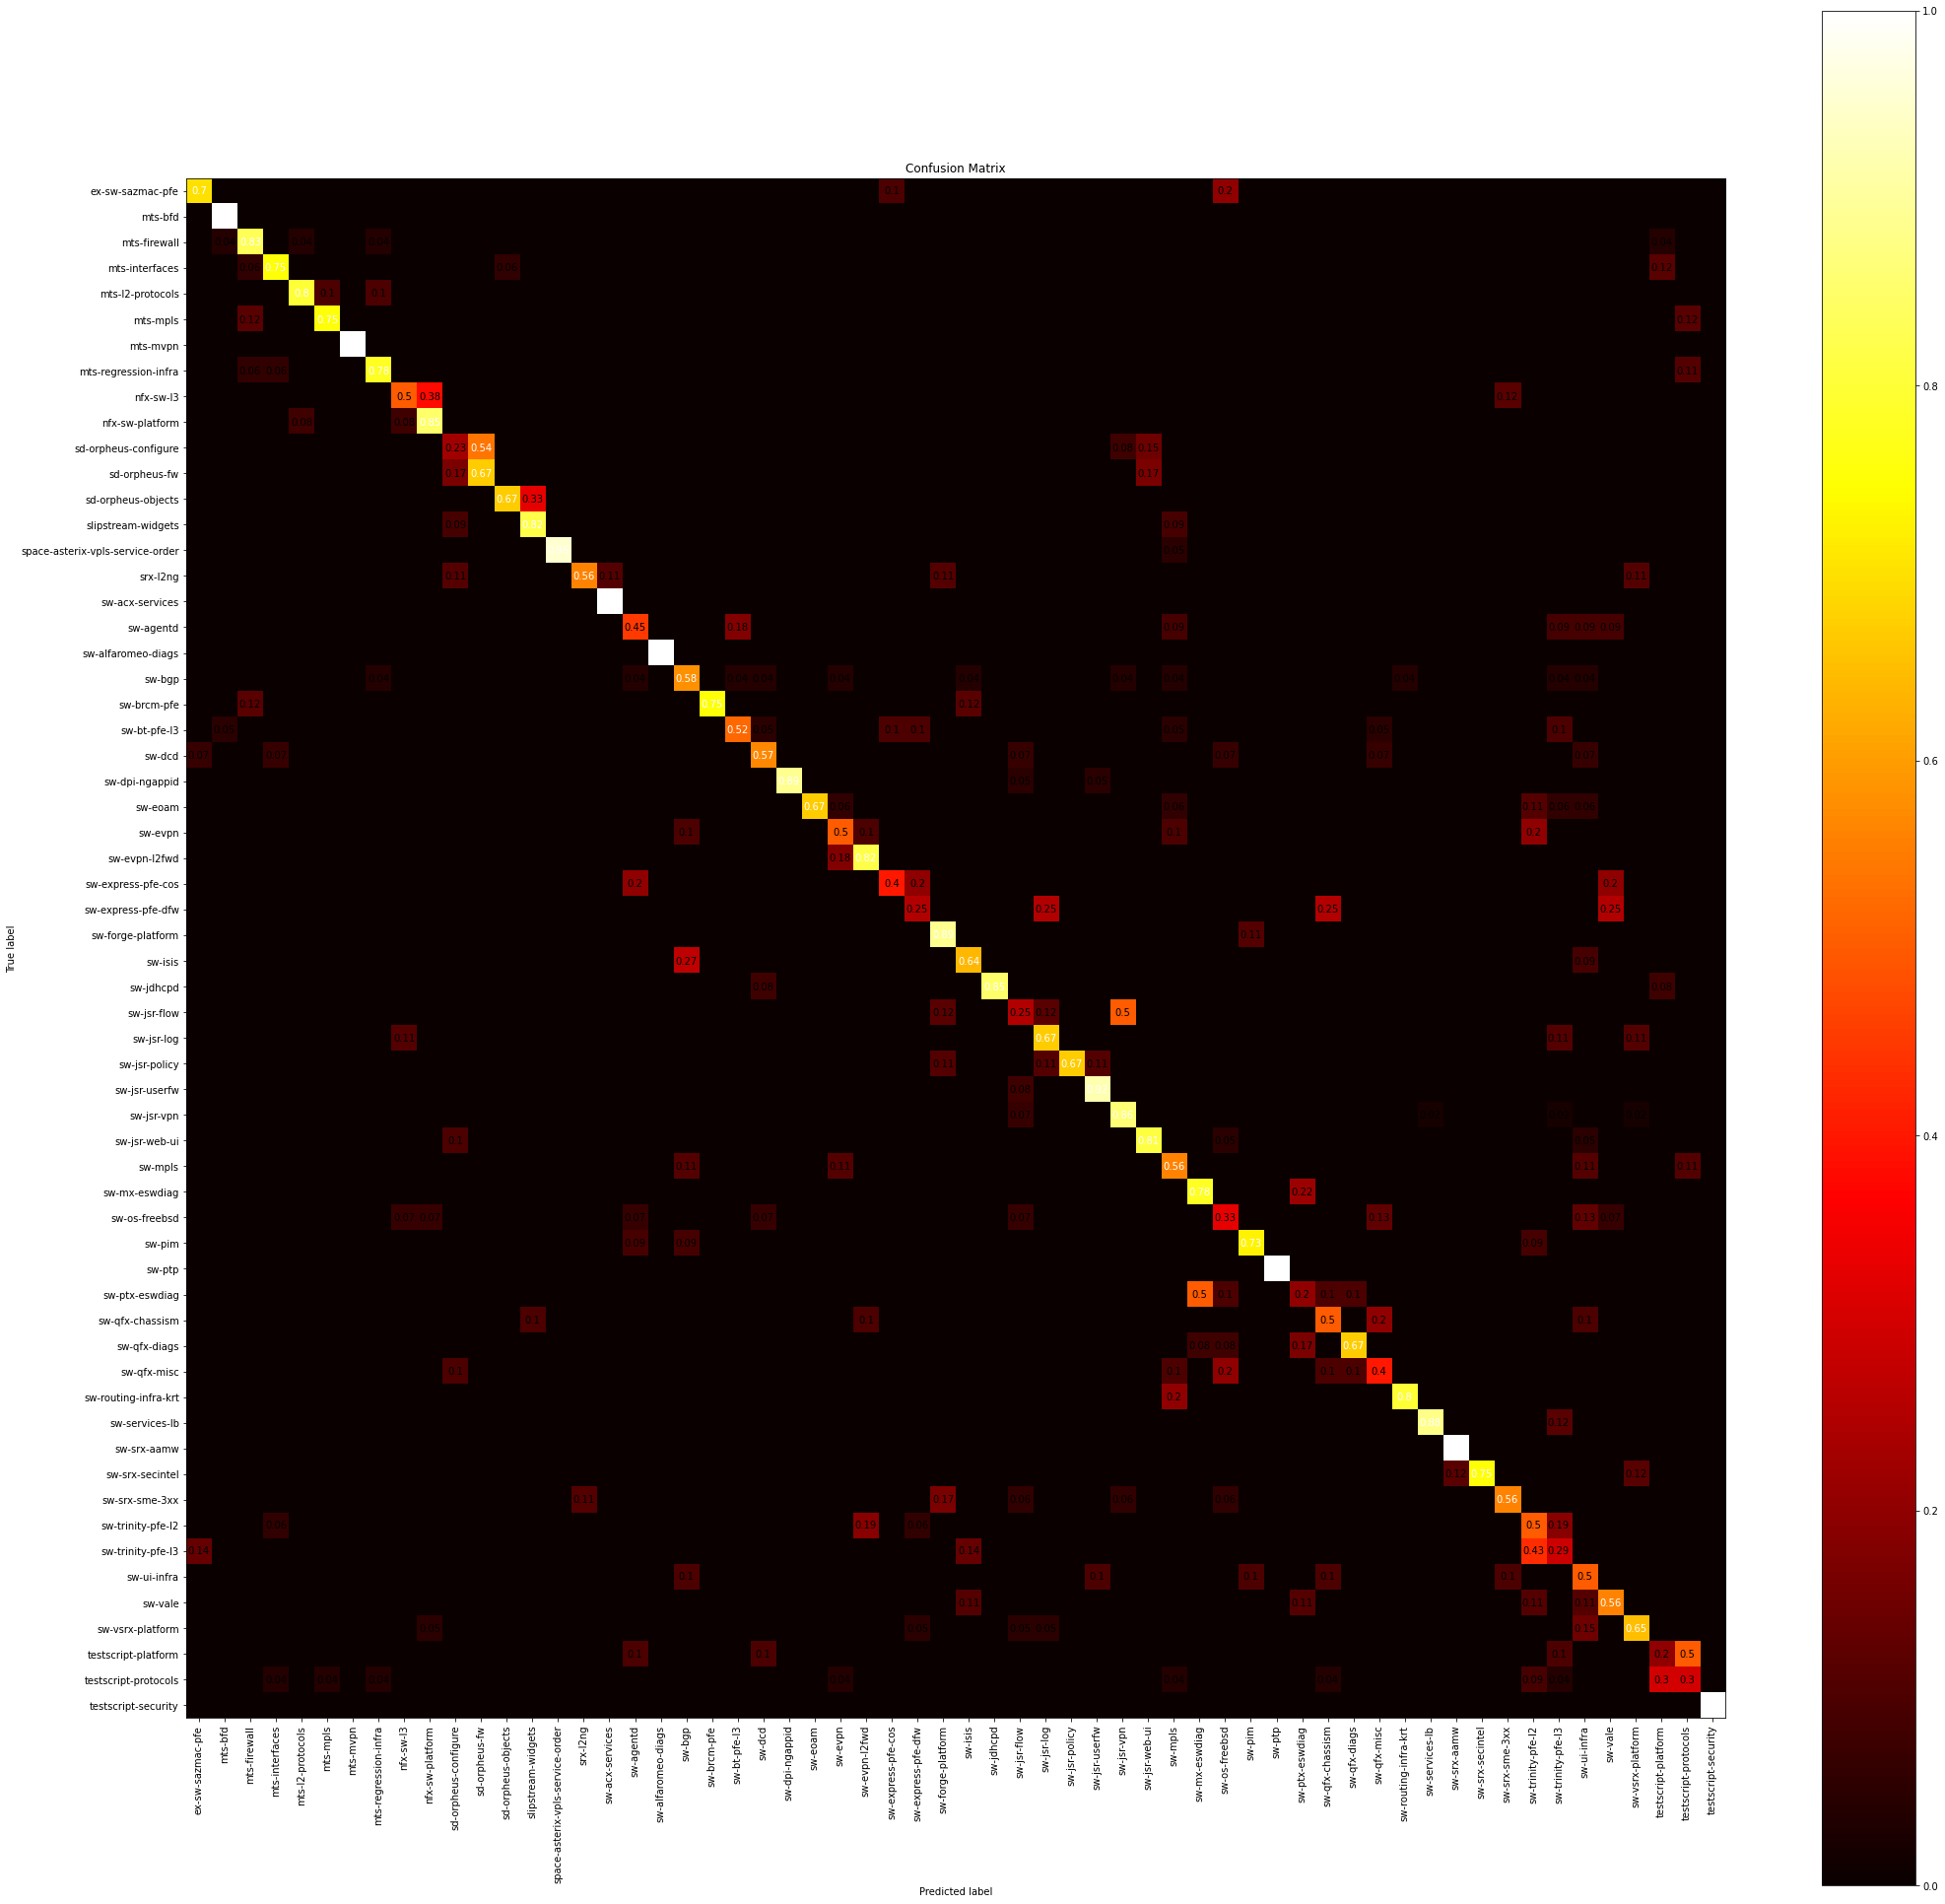

In [18]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_real, y_pred,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="hot",
                                    hide_zeros=True,
                                    figsize=(35, 35)
                                    );
plt.xticks(rotation=90);